# <span style="color:red">Final Exam - Open Solutions</span>

## FINM 37500 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Points
* You have `100` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo - you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

The exam uses the following file,
`data/fiderivs_2025-03-10.xlsx`

- Section 1 uses the following sheets:
    * `rate curves`
    * quarterly spaced and quarterly compounded rates

- Section 2 uses the following sheets:
    * `rate tree`
    * continuously-compounded rate tree

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 75     |
| 2       | 25     |

Numbered problems are worth 5pts unless specified otherwise.

***

## Submitting your Exam

Submission
* You will upload your solution to the `Exam - Open` assignment on Canvas. 
* Submit a compressed, "zipped", folder containing all code according to the file structure below.
* Name your submitted, zipped, folder `exam-open-LASTNAME-FIRSTNAME.zip`.
* Be sure to **submit** on Canvas, not just **save** on Canvas.

Your submission should **include all code and data used in your analysis** in the following folder structure.
* We strongly prefer all submissions are structred this way, and it will improve grading accuracy for partial credit. 
* Still, if you're struggling to get this working in time, no worries; just structure as comfortable and submit **everything used** for your submission.

__Exam Submission Structure:__

```plaintext
exam-open-LASTNAME-FIRSTNAME.zip/
│── exam-open.ipynb
│── data/
│   ├── example_data.csv
│── modules/
│   ├── my_functions.py

### Validating your folder structure

The next cell tests that you have this folder structure implemented.

In [1]:
from pathlib import Path
import sys
import pandas as pd

# Get the directory of the notebook (assumes Jupyter Notebook is always used)
BASE_DIR = Path().resolve()

# Define paths for data and modules
DATA_DIR = BASE_DIR / "data"
MODULES_DIR = BASE_DIR / "modules"

# Check if expected directories exist
if not DATA_DIR.exists():
    print(f"Warning: Data directory '{DATA_DIR}' not found. Check your file structure.")

if not MODULES_DIR.exists():
    print(f"Warning: Modules directory '{MODULES_DIR}' not found. Check your file structure.")

# Ensure Python can import from the modules directory
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))

# Load exam data
EXAMPLE_DATA_PATH = DATA_DIR / "fiderivs_2025-03-10.xlsx"

if EXAMPLE_DATA_PATH.exists():
    example_data = pd.read_excel(EXAMPLE_DATA_PATH)
else:
    print(f"Warning: '{EXAMPLE_DATA_PATH.name}' not found. Ensure it's in the correct directory.")


***

## Solution Functions

In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [3]:
import numpy as np
from scipy.optimize import fsolve, minimize

In [4]:
sys.path.insert(0, '../cmds')
from fiderivs import price_bond_textbook
from ficcvol import flat_to_forward_vol, cap_vol_to_price

This messy function is used in `1.5`.

One could easily have used the (previously utilized) functions

`from ratecurves import discounts_to_swaprates, spotcurve_to_discountcurve, spotcurve_to_forwardcurve`

In [5]:
def recalc_rates_from_spot(spot_rates, compounding=None):
    """
    Recalculate discount factors, forward rates, and swap rates from a spot rate Series.
    
    The input spot rates are assumed to be annualized and are provided for maturities 
    (in years) that may be spaced arbitrarily (e.g., 1, 0.5, 0.25, etc.).
    
    Parameters:
        spot_rates (pd.Series): Annualized spot rates (as decimals) indexed by maturity.
        compounding (float or None): 
            - If a number (e.g., 1, 2, 4, etc.), it represents the discrete compounding frequency per year.
              In this case, discount factors are computed as 
                  D(t) = 1 / (1 + R(t)/m)^(m*t)
              and the forward rate from t1 to t2 is
                  F = m * { [D(t1)/D(t2)]^(1/(m*(t2-t1))) - 1 }.
            - If None, continuous compounding is assumed with
                  D(t) = exp(-R(t)*t)
              and the forward rate is
                  F = ln(D(t1)/D(t2)) / (t2-t1).
    
    Swap rates are computed assuming that payments occur at the times given by the index.
    For a swap maturing at time T, the swap rate is:
          S(T) = (1 - D(T)) / (sum_i alpha_i * D(t_i))
    where the accrual factors alpha_i are computed as:
          alpha_1 = t1 (assuming time 0 to t1)
          alpha_i = t_i - t_(i-1)  for i > 1.
    
    Returns:
        pd.DataFrame: A DataFrame with the input "spot rates" and the computed "discounts",
                      "forwards", and "swap rates" as columns.
    """
    # Ensure spot_rates is sorted by maturity.
    spot_rates = spot_rates.copy()
    spot_rates = spot_rates.sort_index()
    
    # Initialize Series for calculations.
    discounts = pd.Series(index=spot_rates.index, dtype=float)
    forwards  = pd.Series(index=spot_rates.index, dtype=float)
    swap_rates = pd.Series(index=spot_rates.index, dtype=float)
    
    # Calculate discount factors.
    for t in spot_rates.index:
        R_t = spot_rates[t]
        if compounding is None:
            # Continuous compounding
            discounts[t] = np.exp(-R_t * t)
        else:
            m = compounding  # discrete compounding frequency per year
            discounts[t] = 1 / ((1 + R_t / m) ** (m * t))
    
    # Calculate forward rates for the interval from the previous payment time to the current one.
    index_vals = list(spot_rates.index)
    for i, t in enumerate(index_vals):
        if i == 0:
            forwards[t] = spot_rates[t]  # For the first period, use the spot rate.
        else:
            t_prev = index_vals[i - 1]
            delta = t - t_prev  # interval between payment times
            if compounding is None:
                forwards[t] = np.log(discounts[t_prev] / discounts[t]) / delta
            else:
                m = compounding
                forwards[t] = m * (((discounts[t_prev] / discounts[t]) ** (1 / (m * delta))) - 1)
    
    # Calculate swap rates using accrual factors that reflect the actual spacing.
    for t in index_vals:
        # Get all payment times up to and including t.
        payment_times = [pt for pt in index_vals if pt <= t]
        accruals = []
        for j, pt in enumerate(payment_times):
            if j == 0:
                accrual = pt  # from time 0 to first payment time
            else:
                accrual = pt - payment_times[j - 1]
            accruals.append(accrual)
        # Sum of (accrual * discount factor) for each payment.
        weighted_sum = sum(accrual * discounts[pt] for pt, accrual in zip(payment_times, accruals))
        swap_rates[t] = (1 - discounts[t]) / weighted_sum
    
    # Build the resulting DataFrame.
    results = pd.DataFrame({
        "spot rates": spot_rates,
        "discounts": discounts,
        "forwards": forwards,
        "swap rates": swap_rates
    })
    
    return results

The following messy function values the portfolio (structured note) for a given sized "shock" (parallel shift in spot rates.)

Useful for calculating duration, OAS, and plotting how value of the instrument varies with rates.

See problems `1.6`-`1.10.`

In [6]:
def price_structured(shock,spotrates,vols,cpn,strikes,freq_cpn=2,freq_curve=2,T=None,notional=100,contracts=None,voltype='flat'):
    
    if T is None:
        T = spotrates.index[-1]

    if voltype=='flat':
        if np.isscalar(vols):
            flatvols = np.full_like(strikes,vols)
        else:
            flatvols = vols.copy()
        
    else:
        fwdvols = vols

    spotshock = spotrates+shock
    
    curves = recalc_rates_from_spot(spotshock,compounding=freq_curve)
    swaps = curves['swap rates']
    discs = curves['discounts']
    fwds = curves['forwards']
        
    values = pd.DataFrame(dtype=float,columns=['black'],index=contracts.index)
    values.loc['bond','black'] = price_bond_textbook(swaps.loc[T],T,cpn,cpnfreq=freq_cpn)

    capfloor_prices = pd.DataFrame(dtype=float,columns=['cap','floor'],index=strikes)

    for s,strike in enumerate(strikes):
        if voltype=='flat':
            capfloor_prices.loc[strike,'cap'] = cap_vol_to_price(flatvols[s], strike, fwds, discs, dt=1/freq_curve, notional=notional, isPayer=True)
            capfloor_prices.loc[strike,'floor'] = cap_vol_to_price(flatvols[s], strike, fwds, discs, dt=1/freq_curve, notional=notional, isPayer=False)
        else:
            capfloor_prices.loc[strike,'cap'] = cap_fwdvol_to_price(fwdvols, strike, fwds, discs, freq_cap=freq_curve, notional=notional, isCall=True)
            capfloor_prices.loc[strike,'floor'] = cap_fwdvol_to_price(fwdvols, strike, fwds, discs, freq_cap=freq_curve, notional=notional, isCall=False)
    
    values.loc[['cap ATM','floor ATM'],'black'] = capfloor_prices.iloc[1,:].values
    values.loc['cap OTM','black'] = capfloor_prices['cap'].iloc[-1]
    values.loc['floor OTM','black'] = capfloor_prices['floor'].iloc[0]
    
    tab_nav = (values['black'] * contracts).to_frame().rename(columns={0:'nav'})
    tab_nav.loc['portfolio'] = tab_nav.sum()

    return tab_nav

***

# 1.

Consider the following rate data.

In [7]:
DATE = '2025-03-10'
FILEIN = f'../data/fiderivs_{DATE}.xlsx'

sheet_curves = f'rate curves'

curves = pd.read_excel(FILEIN, sheet_name=sheet_curves).set_index('tenor')
#curves.drop(columns=['fwd vols'],inplace=True)
curves.style.format('{:.1%}').format_index('{:.2f}')

,swap rates,spot rates,discounts,forwards,flat vols
tenor,,,,,
0.25,4.2%,4.2%,99.0%,nan%,nan%
0.50,4.1%,4.1%,98.0%,4.0%,14.6%
0.75,4.0%,4.0%,97.1%,3.7%,16.9%
1.00,3.9%,3.9%,96.2%,3.6%,19.1%
1.25,3.8%,3.8%,95.4%,3.4%,22.2%
1.50,3.7%,3.7%,94.6%,3.4%,24.5%
1.75,3.7%,3.7%,93.8%,3.4%,26.1%
2.00,3.7%,3.7%,93.0%,3.5%,27.2%
2.25,3.6%,3.6%,92.2%,3.4%,27.9%


### 1.1.

Price a fixed-rate bond with the following specifications...
* T = `5`
* coupons are paid `quarterly`.
* coupon rate is `3.6%` (quarterly).

Note: 
* Use the discount curves provided.
* Use the usual bond-pricing formula.
* The clean and dirty price are the same, as we assume the bond has just been issued.

<span style="color: red;">
Solution:

In [8]:
instruments = ['bond','cap ATM','floor ATM','cap OTM','floor OTM']
values = pd.DataFrame(dtype=float,columns=['black'],index=instruments)

In [9]:
NOTIONAL = 100
T = 5

CPNFREQ = 4
CPN = .036

CMPND_RATECURVES = 4
FREQCURVE = 4
FREQ_CURVE = FREQCURVE

In [10]:
spot_ytm = curves.loc[T,'swap rates']
discs = curves['discounts']
values.loc['bond','black'] = price_bond_textbook(spot_ytm,T,CPN,cpnfreq=CPNFREQ)
values.style.format('{:.2f}',na_rep='')

,black
bond,99.94
cap ATM,
floor ATM,
cap OTM,
floor OTM,


### 1.2.

As usual, the provided cap/floor quotes correspond to caps/floors...
* notional of `$100`
* struck at-the-money, `ATM`.
* with expiration `T`.
* with `quarterly` caplets / floorlets.
* depending on the reference rate, in arrears.

Note that, as usual,
* We assume that the reference rate is compounded the same as the interest rates in the provided data. Thus, no adjustment is needed to the compounding.

Calculate and report the forward volatilities stripped from the caps.

<span style="color: red;">
Solution:

In [11]:
capvols = flat_to_forward_vol(curves,FREQ_CURVE)
capvols[['fwd vols']].style.format('{:.2%}',na_rep='').format_index('{:.2f}')

,fwd vols
tenor,
0.25,
0.50,14.63%
0.75,18.70%
1.00,22.34%
1.25,29.01%
1.50,30.66%
1.75,31.48%
2.00,31.46%
2.25,30.75%


### 1.3. (15pts)

Price caps and floors continuing with the assumptions above. Except calculate the prices for a range of strikes...

* cap struck `ATM`.
* floor struck `ATM`.
* cap struck `+150bps`.
* floor struck `-150bps`.

Report the 
* three strikes, ATM adjusted by (-150, 0, +150).
* the dollar value of the four instruments.

Note that 
* you do not need the forward vols calculated in `1.2` to price these caps/floors. The flat vols are sufficient.

<span style="color: red;">
Solution:

In [12]:
STRIKES_OFFSET = np.array([-150,0,150])

In [13]:
strikeATM = curves.loc[T,'swap rates']
strikes = strikeATM + STRIKES_OFFSET/100/100

pd.DataFrame(strikes,index=STRIKES_OFFSET,columns=['strike']).style.format('{:.2%}')

,strike
-150,2.11%
0,3.61%
150,5.11%


In [14]:
capfloor_prices = pd.DataFrame(dtype=float,columns=['cap','floor'],index=STRIKES_OFFSET)

for offset,strike in zip(STRIKES_OFFSET,strikes):
    capfloor_prices.loc[offset,'cap'] = cap_vol_to_price(curves.loc[T,'flat vols'], strike, curves.loc[:,'forwards'], curves.loc[:,'discounts'], dt=1/FREQCURVE, notional=NOTIONAL, isPayer=True)
    capfloor_prices.loc[offset,'floor'] = cap_vol_to_price(curves.loc[T,'flat vols'], strike, curves.loc[:,'forwards'], curves.loc[:,'discounts'], dt=1/FREQCURVE, notional=NOTIONAL, isPayer=False)
    
capfloor_prices.style.format('{:.2f}')

,cap,floor
-150,6.62,0.31
0,2.49,2.64
150,0.91,7.52


In [15]:
values.loc[['cap ATM','floor ATM'],'black'] = capfloor_prices.loc[0,:].values
values.loc['cap OTM','black'] = capfloor_prices['cap'].iloc[-1]
values.loc['floor OTM','black'] = capfloor_prices['floor'].iloc[0]
values.style.format('{:.2f}')

,black
bond,99.94
cap ATM,2.49
floor ATM,2.64
cap OTM,0.91
floor OTM,0.31


### 1.4.

Price a portfolio comprised of the positions in the table. (The positions are listed as "contracts" where each contract has face or notional of $100.)

In [16]:
contracts = pd.DataFrame(data=[1,1,-1,-1,1],columns = ['contracts'],index=values.index)
contracts.style.format('{:.0f}',na_rep='')

,contracts
bond,1
cap ATM,1
floor ATM,-1
cap OTM,-1
floor OTM,1


<span style="color: red;">
Solution:

In [17]:
nav = (values['black'] * contracts['contracts']).to_frame().rename(columns={0:'nav'})
nav.loc['portfolio'] = nav.sum()
nav.style.format('{:.2f}')

,nav
bond,99.94
cap ATM,2.49
floor ATM,-2.64
cap OTM,-0.91
floor OTM,0.31
portfolio,99.19


### 1.5. (10pts)

Suppose all spot rates are shocked by 1bp.

Report the new
* discount factors
* forward rates
* swap rates

(The latter two should still be quarterly compounded.)

Note that...
* We are not revising flat or forward vols.

<span style="color: red;">
Solution:

In [18]:
SHOCK = 1/100/100
spotrates = curves['spot rates']
spotshock = spotrates+SHOCK
curves_shock = recalc_rates_from_spot(spotshock,compounding=FREQ_CURVE)
curves_shock.style.format('{:.2%}').format_index('{:.2f}')

,spot rates,discounts,forwards,swap rates
tenor,,,,
0.25,4.23%,98.95%,4.23%,4.23%
0.50,4.10%,97.98%,3.98%,4.10%
0.75,3.98%,97.07%,3.75%,3.99%
1.00,3.89%,96.20%,3.61%,3.89%
1.25,3.79%,95.39%,3.40%,3.80%
1.50,3.73%,94.59%,3.40%,3.73%
1.75,3.69%,93.78%,3.44%,3.69%
2.00,3.66%,92.97%,3.49%,3.67%
2.25,3.63%,92.19%,3.40%,3.64%


### 1.6. (10pts)

Calculate the numerical duration.
* increase all the spot rates by 1bp. 
* use the revised rates from `1.5.` corresponding to this shock.
* re-price the portfolio.

Report the 
* esitmated duration for each component of the portfolio.
* duration of the total portfolio.

<span style="color: red;">
Solution:

In [19]:
nav_shock = price_structured(SHOCK,curves['spot rates'],capvols.loc[T,'flat vols'],CPN,strikes=strikes,freq_cpn=CPNFREQ,freq_curve=FREQCURVE,contracts=contracts['contracts'],notional=NOTIONAL,voltype='flat')

duration = -(nav_shock - nav) / nav / SHOCK
duration.style.format('{:.2f}').set_caption('duration')

,nav
bond,4.56
cap ATM,-97.09
floor ATM,71.48
cap OTM,-110.61
floor OTM,100.63
portfolio,1.59


### 1.7. (8pts)

The market is quoting this portfolio at a price of `100.00.`

Compute and report the **option-adjusted spread (OAS)** of this portfolio.
* Continue to model the changing rate as moving the spot rate in a parallel fashion, changing the other curves, but leaving the flat vols unchanged.

<span style="color: red;">
Solution:

In [20]:
MKT_QUOTE = 100

wrapper = lambda shock: MKT_QUOTE - price_structured(shock,curves['spot rates'],capvols.loc[T,'flat vols'],CPN,strikes=strikes,freq_cpn=CPNFREQ,freq_curve=FREQCURVE,contracts=contracts['contracts'],notional=NOTIONAL).loc['portfolio','nav']
oas = pd.DataFrame(fsolve(wrapper,0)[0],index=['black'],columns=['OAS'])
oas.style.format('{:.2%}')

,OAS
black,-0.53%


### 1.8. (5pts)

We know that the vol varies with the strike, yet we used the same implied vol for the ATM and OTM caps/floors. We now consider how much the OTM flat volatility would differ from the ATM flat volatility.

A SABR curve has been fit to OTM cap/floor flat vols, and the parameters are below.

In [21]:
sabr_parameters = pd.DataFrame(
    {'beta': 0.2500,
    'alpha': 0.0214,
    'nu': 0.6000,
    'rho': -0.2000
    },
    index=['parameter']).T

sabr_parameters.style.format('{:.4f}').set_caption('SABR (full)')

,parameter
beta,0.2500
alpha,0.0214
nu,0.6000
rho,-0.2000


Use the SABR curve to report the implied flat vols for the OTM cap and floor.
* The SABR curve requires a forward rate. Input the $T$-time forward rate provided in the data file.
* There are some nuances around using SABR for caps/floors which we are skipping. Just proceed with the instruction above.

<span style="color: red;">
Solution:

In [22]:
from volskew import sabr
import matplotlib.pyplot as plt

In [23]:
strikegrid = strikes
BETA = sabr_parameters.loc['beta','parameter']
nustar = sabr_parameters.loc['nu','parameter']
rhostar = sabr_parameters.loc['rho','parameter']
alphastar = sabr_parameters.loc['alpha','parameter']
F = curves.loc[T,'forwards']

ivolgrid = sabr(BETA,nustar,rhostar,alphastar,F,strikegrid,T)    
sabrcurve = pd.DataFrame(ivolgrid,index=strikegrid,columns=['flat vol'])
sabrcurve.style.format('{:.1%}').format_index('{:.1%}')

,flat vol
2.1%,43.5%
3.6%,29.3%
5.1%,26.2%


### 1.9. (5pts)

No matter what you calculated in `1.8.`, proceed with implied OTM flat vols as seen in the table below

Use these to recalculate the value of the portfolio. That is, revise your answer to `1.4.`

In [24]:
flat_vols_otm = pd.DataFrame([.50,.25],index=STRIKES_OFFSET[[0,2]],columns=['flat vols'])
flat_vols_otm.index.name = 'OTM spread (bps)'
flat_vols_otm.style.format('{:.1%}')

,flat vols
OTM spread (bps),
-150,50.0%
150,25.0%


<span style="color: red;">

Solution:



In [25]:
shock = 0/100/100

flatvol_list = np.array([flat_vols_otm['flat vols'].iloc[0], curves.loc[T,'flat vols'], flat_vols_otm['flat vols'].iloc[1]])
nav_adj = price_structured(shock,curves['spot rates'],flatvol_list,CPN,strikes=strikes,freq_cpn=CPNFREQ,freq_curve=FREQCURVE,contracts=contracts['contracts'],notional=NOTIONAL,voltype='flat')
nav_adj.style.format('{:.2f}')

,nav
bond,99.94
cap ATM,2.49
floor ATM,-2.64
cap OTM,-0.70
floor OTM,1.27
portfolio,100.37


### 1.10. (7pts)

Make a plot of the portfolio value for a range of parallel interest rate shocks.

<span style="color: red;">

Range was unspecified. Below is range of `-300bps to +300bps`

Do you see any convexity? Conceptually, (without being tied to your specific numerical answers) do you think there should be any convexity in the relationship?

<span style="color: red;">

Solution:

<Axes: >

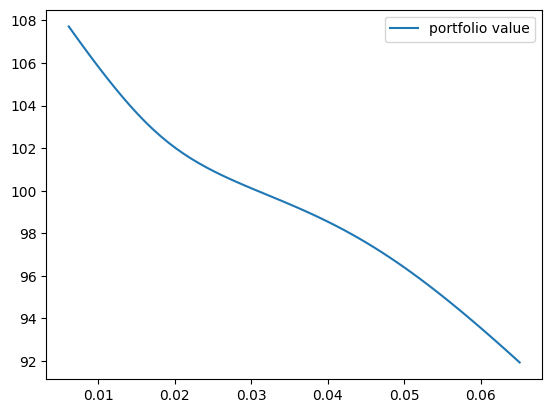

In [26]:
shockgrid = np.arange(-.03,.03,.001)
valgrid = pd.DataFrame(dtype=float,index=shockgrid+strikeATM,columns=['portfolio value'])
for shock in shockgrid:    
    valgrid.loc[shock+strikeATM] = price_structured(shock,curves['spot rates'],capvols.loc[T,'flat vols'],CPN,strikes=strikes,freq_cpn=CPNFREQ,freq_curve=FREQCURVE,contracts=contracts['contracts'],notional=NOTIONAL,voltype='flat').loc['portfolio','nav']

valgrid.plot()

<span style="color: red;">

Without even looking at a graph, we could infer that it will have positive convexity in lower ranges of interest rates, with negative convexity in higher ranges of interest rates.

* Where the coupon becomes fixed and it looks like a typical fixed-rate bond.
* In the mid range, it looks like a floating-rate note, with nearly zero convexity.
* In high rates, it has negative convexity, for being short an option.

***

# 2.

Consider the following interest-rate tree which fits the data from Section 1.

Rates are continuously compounded.

In [27]:
sheet_tree = 'rate tree'

ratetree = pd.read_excel(FILEIN, sheet_name=sheet_tree).set_index('state')
ratetree.columns.name = 'time'

ratetree.style.format('{:.1%}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75
state,,,,,,,,,,,,,,,,,,,,
0,4.2%,4.2%,4.3%,4.7%,5.2%,6.6%,8.0%,9.6%,10.8%,12.5%,14.1%,15.9%,17.5%,20.1%,24.1%,27.8%,30.6%,33.4%,37.3%,41.3%
1,,3.7%,3.7%,3.9%,4.1%,5.0%,5.9%,7.0%,7.9%,9.2%,10.5%,11.9%,13.2%,15.1%,18.1%,20.8%,23.0%,25.3%,28.4%,31.6%
2,,,3.2%,3.2%,3.3%,3.7%,4.3%,5.1%,5.8%,6.8%,7.8%,8.9%,9.9%,11.3%,13.5%,15.6%,17.3%,19.1%,21.7%,24.2%
3,,,,2.7%,2.6%,2.8%,3.2%,3.7%,4.2%,5.0%,5.8%,6.7%,7.4%,8.5%,10.2%,11.7%,13.0%,14.5%,16.5%,18.5%
4,,,,,2.1%,2.1%,2.3%,2.7%,3.1%,3.7%,4.3%,5.0%,5.6%,6.4%,7.6%,8.8%,9.8%,11.0%,12.6%,14.1%
5,,,,,,1.6%,1.7%,2.0%,2.2%,2.7%,3.2%,3.7%,4.2%,4.8%,5.7%,6.6%,7.4%,8.3%,9.6%,10.8%
6,,,,,,,1.3%,1.5%,1.6%,2.0%,2.4%,2.8%,3.2%,3.6%,4.3%,4.9%,5.5%,6.3%,7.3%,8.3%
7,,,,,,,,1.1%,1.2%,1.5%,1.7%,2.1%,2.4%,2.7%,3.2%,3.7%,4.2%,4.8%,5.6%,6.3%
8,,,,,,,,,0.9%,1.1%,1.3%,1.6%,1.8%,2.0%,2.4%,2.8%,3.1%,3.6%,4.2%,4.8%


### 2.1.

Use the binomial tree to price the vanilla bond from Section 1. (Not the whole portfolio.)

Recall that the bond has `quarterly` coupons.

Report the cashflow tree of this vanilla bond.

<span style="color: red;">
Solution

In [28]:
from binomial import *
sys.path.insert(0, '../dev')
from bintree import *

In [29]:
CMPND_RATETREE = None
dt = ratetree.columns[1] - ratetree.columns[0]
values_binomial = pd.DataFrame(dtype=float,index=['vanilla','structured'],columns=['bond value'])

fsize = (17,8)

In [30]:
SECURITY = 'bond'

trees = dict()
output = bintrees(SECURITY,ratetree,curves,T=T,cpnrate=CPN,cffreq=CPNFREQ,cmpnd_ratetree=CMPND_RATETREE)
output['tree cf'] = output['tree cf'] + ratetree*0
trees['bond'] = output
values.loc['bond','tree'] = output['tree clean'].iloc[0,0]

cftree_allperiods = construct_bond_cftree(T, 1/dt, CPN, CPNFREQ,drop_final_period=False)

CHARTTYPE = 'heatmap'
fmt_cftree = display_bintree_valuation(ratetree,cftree_allperiods,title=f'bond cashflows when paid',charttype=CHARTTYPE,figsize=fsize,fmt='.2f')
fmt_dirty = display_bintree_valuation(ratetree,output['tree dirty'],title=f'{SECURITY} dirty',charttype=CHARTTYPE,figsize=fsize,fmt='.2f')
fmt_clean = display_bintree_valuation(ratetree,output['tree clean'],title=f'bond value',charttype=CHARTTYPE,figsize=fsize,fmt='.2f')

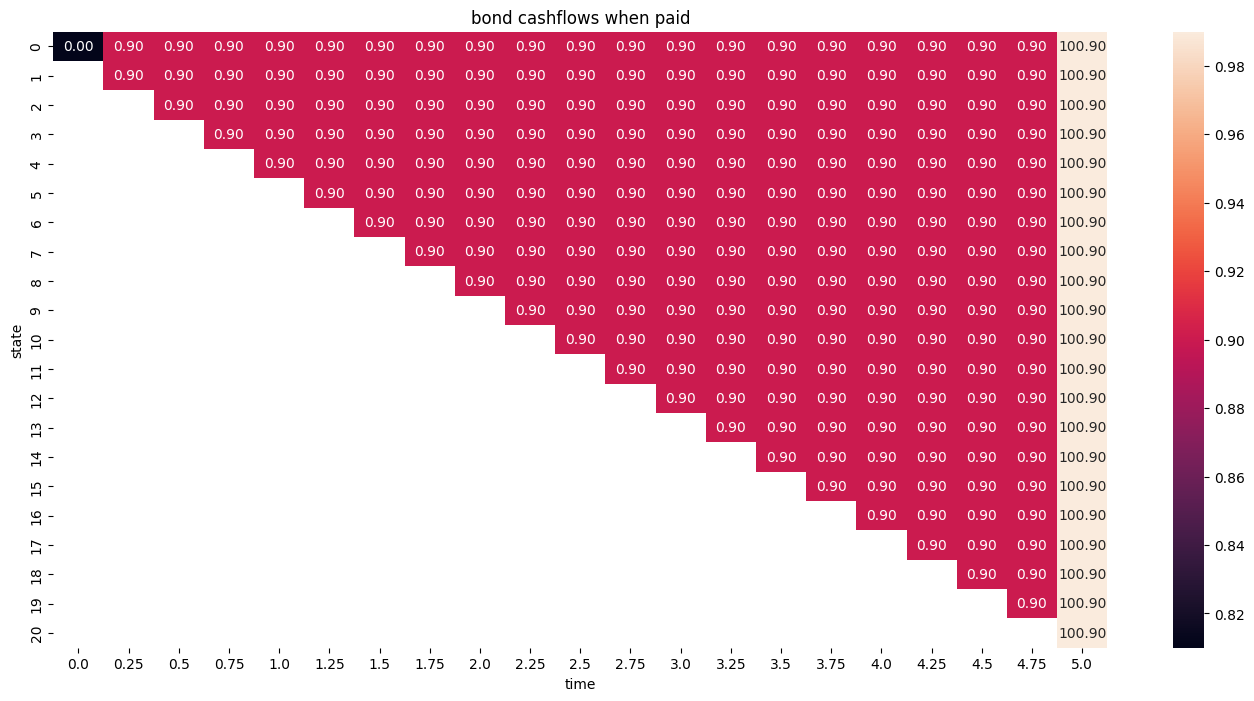

In [31]:
display(fmt_cftree)

#### Complication:

The bond cashflows are listed in the period they are paid, whereas the derivative cashflows are listed in the period they are determined.

It's useful to also see the cashflows when deterimened, discounted back a period. 

This doesn't matter here, as the cashflows are fixed, but it will be more comparable to instruments with rate-dependent cashflows, such as in Section `2.3.`

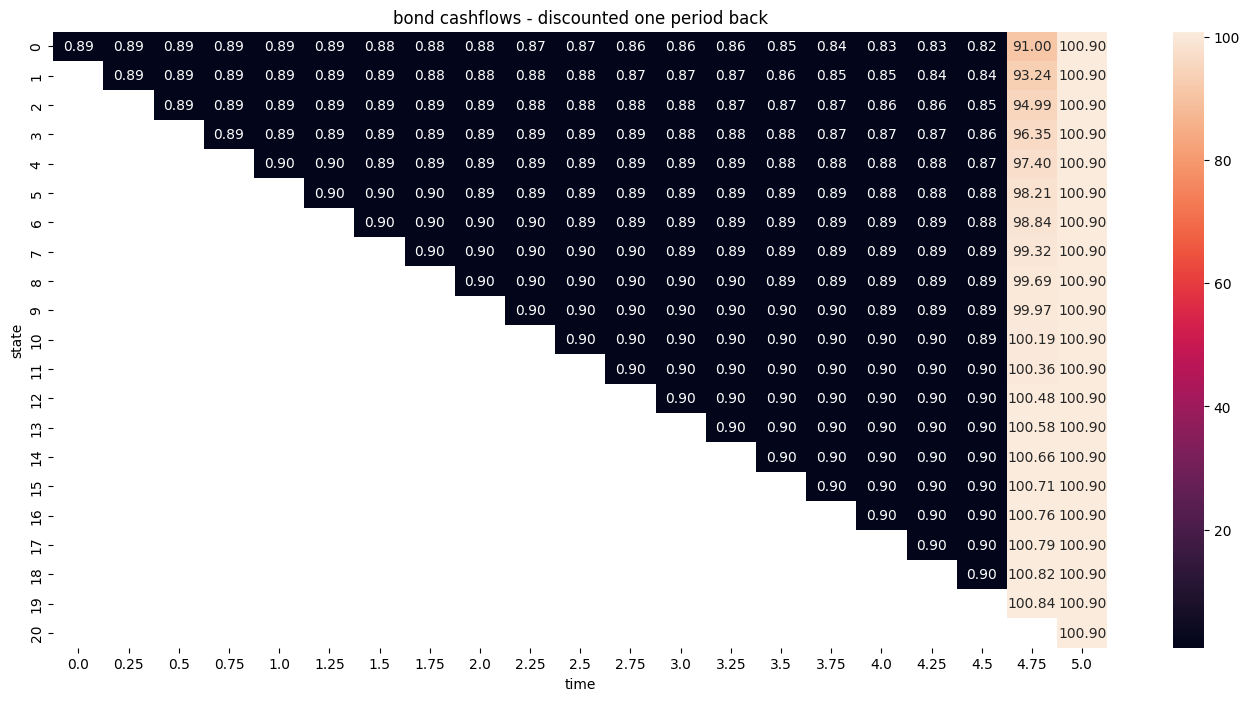

In [32]:
bondtree_cf_arrears = cftree_allperiods.copy()
dt = ratetree.columns[1] - ratetree.columns[0]
for col,t in enumerate(bondtree_cf_arrears.columns[:-1]):
    bondtree_cf_arrears[t] = bondtree_cf_arrears.iloc[:,col+1] * np.exp(-ratetree[t] * dt)

display_bintree_valuation(ratetree,bondtree_cf_arrears,title=f'bond cashflows - discounted one period back',charttype=CHARTTYPE,figsize=fsize,fmt='.2f')

### 2.2. (10pts)

Report the tree of bond values.
* Note that there is no distinction betwen clean and dirty values, as the bond pays a coupon quarterly, so every node is immediately after a coupon, at which point clean and dirty are the same.

<span style="color: red;">
Solution

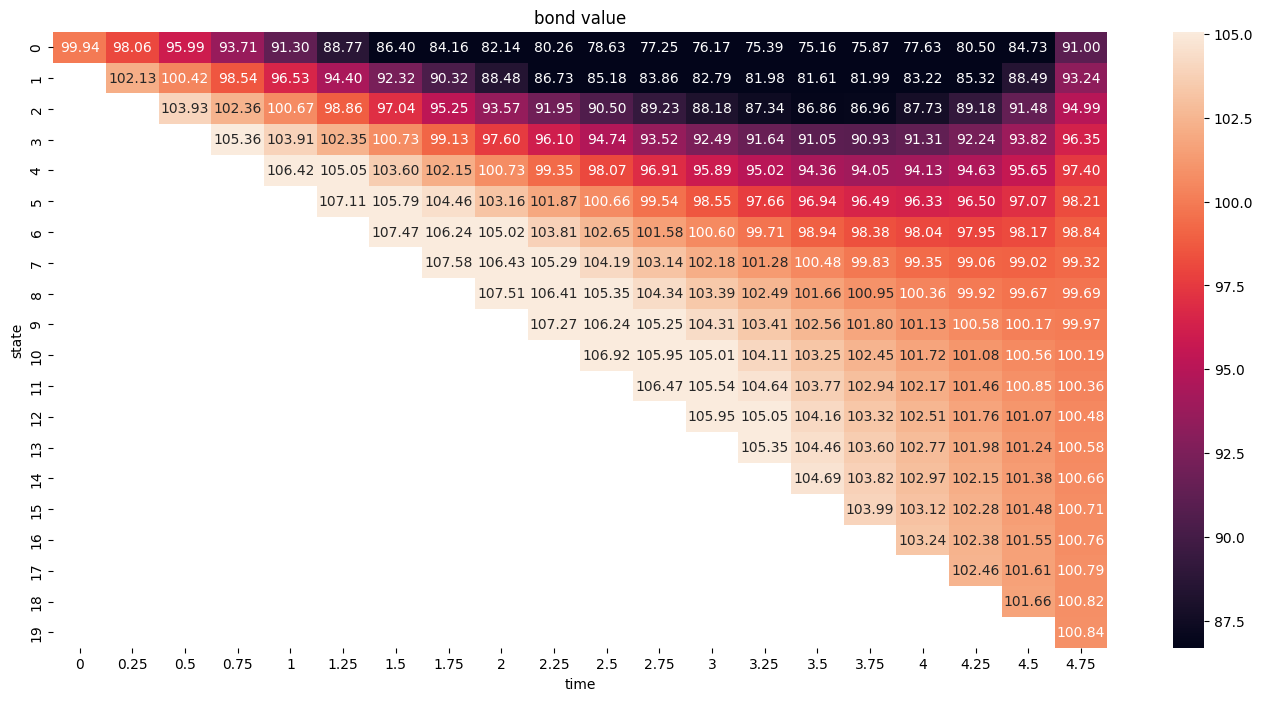

In [33]:
display(fmt_clean)

In [34]:
values_binomial.loc['vanilla'] = output['tree clean'].iloc[0,0]
values_binomial.style.format('{:.2f}',na_rep='')

,bond value
vanilla,99.94
structured,


### 2.3. (10pts)

Report the cashflow tree of a **structured note** defined below.

* Same maturity as the bond in `2.1`.
* Pays quarterly coupons.

But the coupon is more complicated...
* Coupon is the floating rate (in the tree)
* Paid one quarter later. (So set at $t$ and paid out at $t+.25$)
* Coupon cannot go below `2%` reference rate.
* Coupon cannot go above `5%` reference rate.

Note that unlike a vanilla bond, the cashflow depends on the node of the tree, and it determines the cashflow received one step later.

Thus the cashflow tree should show the cashflow **determined** at that node, even though it is paid out one period later. Given this, you should report the determined cashflow, discounted back one period by the continuously-compounded rate at that same node. So this discounted-determined cashflow is solelly a function of the rate at the node.

#### Careful
You are not being asked to report the **valuation** tree of the structured note--just the cashflow tree.

<span style="color: red;">
Solution

<span style="color: red;">

#### Clarification

The problem does not specify whether the variable coupon is based on the continuously-compounded rates in the tree or on a quarterly-compounding of those same rates.

The code below handles either case, based on the `REFRATE_CONTINOUS` logical variable.

In [35]:
REFRATE_CONTINUOUS = False

if REFRATE_CONTINUOUS:
    refratetree = ratetree
else:
    refratetree = compound_rate(ratetree,None,CPNFREQ)

In [36]:
BOUND_LOWER = .02
BOUND_UPPER = .05

<span style="color: red;">

EXTRA: Try the following upper and lower bounds if interested in comparing to the analysis of `Section 1`.

In [37]:
BOUND_LOWER = strikes[0]
BOUND_UPPER = strikes[2]

#### Cashflows at the node determined

Here, they are shown discounted back a period.

In [38]:
func_cpn = lambda r: np.maximum(BOUND_LOWER,np.minimum(BOUND_UPPER,r)) * NOTIONAL / CPNFREQ

cf_determined = func_cpn(refratetree)
cf_determined.iloc[:,-1] += NOTIONAL

Here are the cashflows shown...
* at the node they are determined
* left as notional, not discounted

In the subsequent table, they are shown...
* at the node they are determined
* discounted back one period (using the rate at that same node.)

The problem suggested doing the latter.

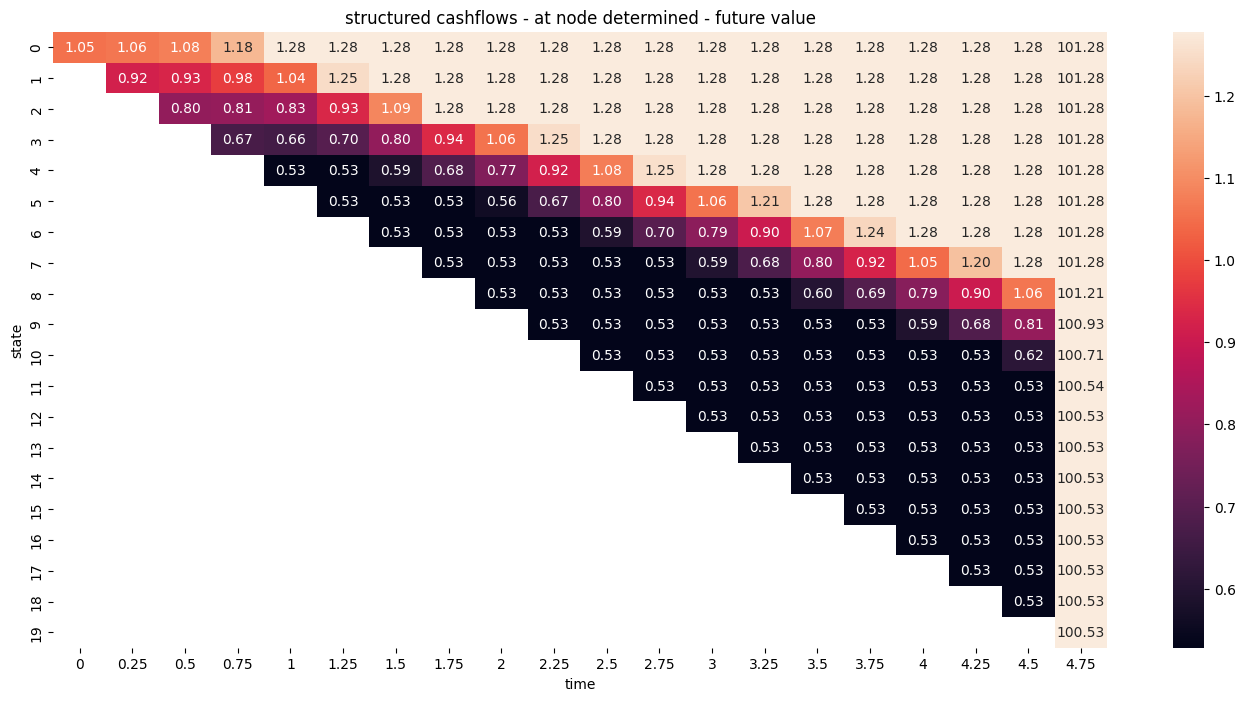

In [39]:
fmt_cf = display_bintree_valuation(ratetree,cf_determined,title=f'structured cashflows - at node determined - future value',charttype=CHARTTYPE,figsize=fsize,fmt='.2f')
display(fmt_cf)

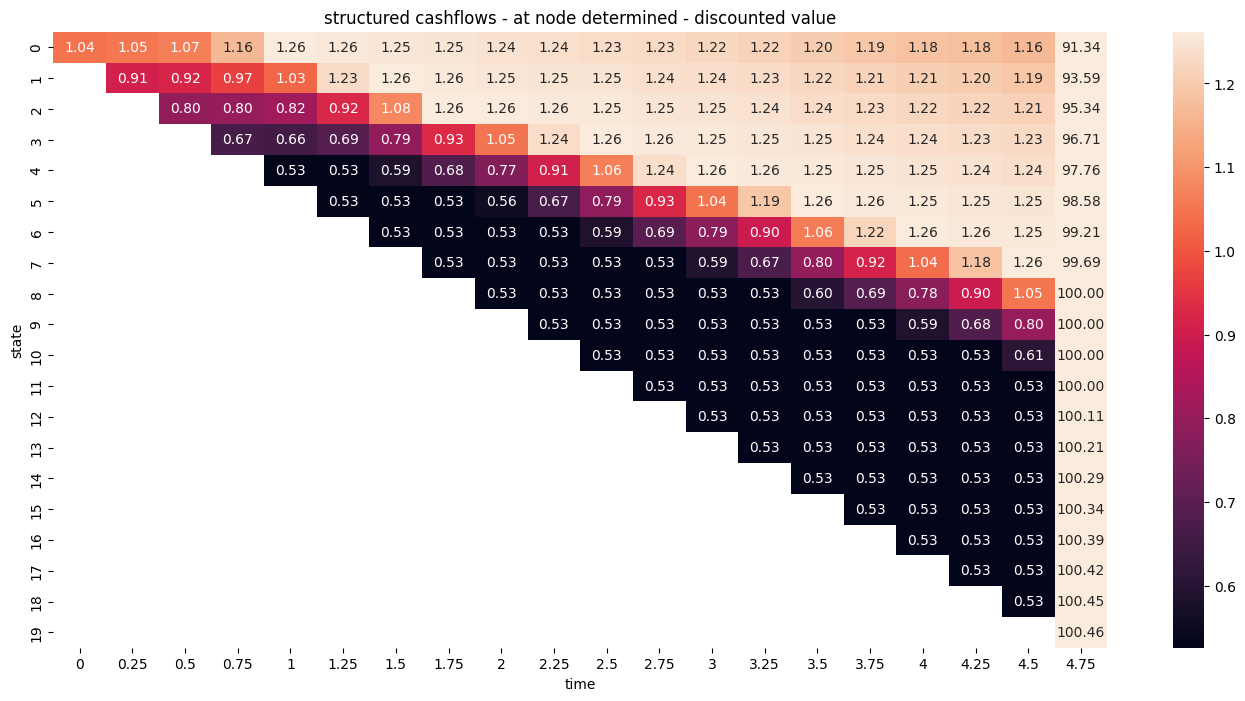

In [40]:
cf_determined_discounted = np.exp(-ratetree * dt) * cf_determined
fmt_cf = display_bintree_valuation(ratetree,cf_determined_discounted,title=f'structured cashflows - at node determined - discounted value',charttype=CHARTTYPE,figsize=fsize,fmt='.2f')
display(fmt_cf)

### Extra: Valuing the Structured Bond

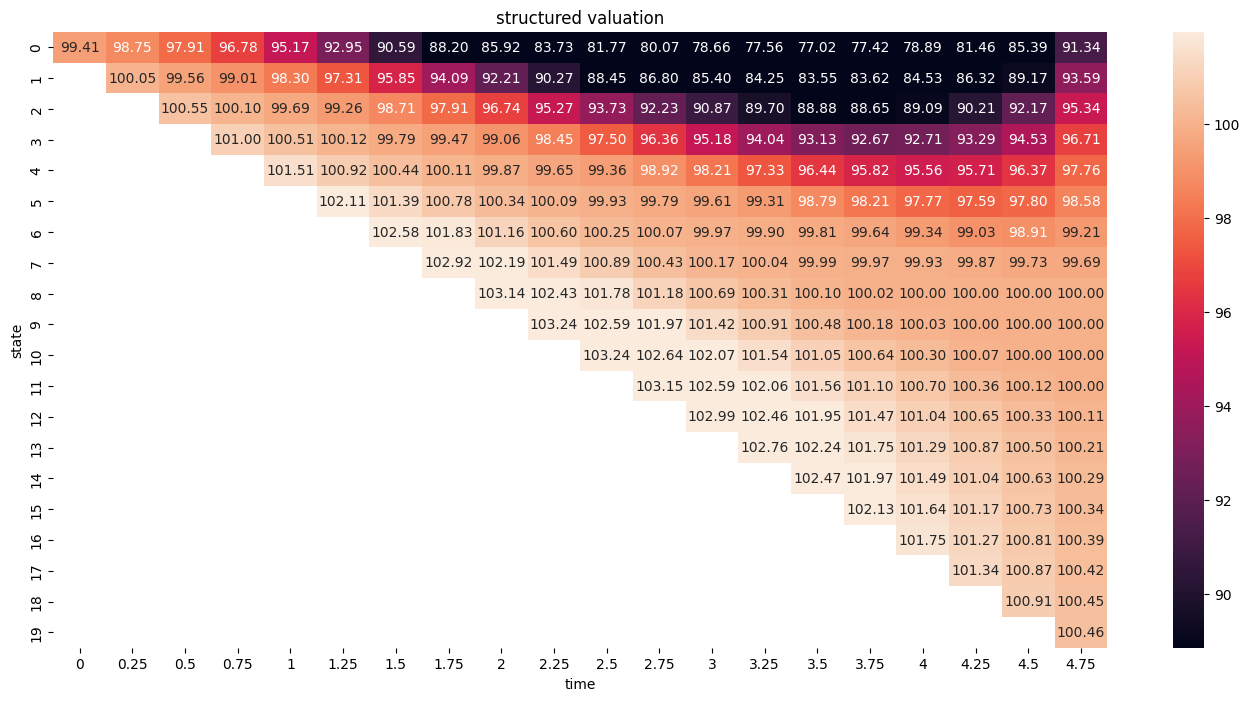

In [41]:
fun_payoff_bond = lambda r: (NOTIONAL + func_cpn(r))

cf_determined.iloc[:,-1] -= NOTIONAL
valtree = bintree_pricing(payoff=fun_payoff_bond,undertree=refratetree,cftree=cf_determined,ratetree=ratetree,cfdelay=True,dt=dt)
fmt_val = display_bintree_valuation(ratetree,valtree,title=f'structured valuation',charttype=CHARTTYPE,figsize=fsize,fmt='.2f')
display(fmt_val)

In [42]:
values_binomial.loc['structured'] = valtree.iloc[0,0]
values_binomial.style.format('{:.2f}',na_rep='')

,bond value
vanilla,99.94
structured,99.41


***

# Addendum - Trees for Valuing the Portfolio in Section 1

Building a binomial tree for each component of the portfolio.

Note that this not the same thing as Section `2.3`, as the strikes are slightly different in the portfolio of `Section 1`. To get them to be approximately the same, 

* Set the coupon of the vanilla bond equal to the current 1-period (t=0.25) spot rate. This ensures the first cashflow is the same for the fixed-rate bond as it would be for the structured note of section 2.3.
* Set the strikes for the long-short cap-floor position to equal this coupon rate rather than setting them ATM.
* With these two modifications, the fixed-rate bond and cap-floor position mimic a floating-rate note.
* The OTM floor-cap then create the bounding effect on the coupon, identical to `Section 2.3.`
* Finally, ensure that the binomial trees calculate the cashflows using the quarterly-compounded refrence rates rather than using the continuously-compounded rates.

Below, we proceed with valuing `Section 1` as written. It differs from `Section 2.3.` but it is still useful to compare the version in `Section 1` from Black's formula to the version from binomial trees.

In [43]:
SECURITY = 'cap'
strike = strikes[1]

output = bintrees(SECURITY,ratetree,curves,undertree=refratetree,T=T,strike=strike,cmpnd_ratetree=CMPND_RATETREE)
values.loc['cap ATM','tree'] = contracts.loc['cap ATM','contracts'] * output['tree value'].iloc[0,0]
values.loc['cap ATM','tree'] = output['tree value'].iloc[0,0]
trees['cap ATM'] = output

In [44]:
SECURITY = 'floor'
strike = strikes[1]

output = bintrees(SECURITY,ratetree,curves,undertree=refratetree,T=T,strike=strike,cmpnd_ratetree=CMPND_RATETREE)
values.loc['floor ATM','tree'] = contracts.loc['floor ATM','contracts'] * output['tree value'].iloc[0,0]
values.loc['floor ATM','tree'] = output['tree value'].iloc[0,0]
trees['floor ATM'] = output

In [45]:
SECURITY = 'cap'
strike = strikes[2]

output = bintrees(SECURITY,ratetree,curves,undertree=refratetree,T=T,strike=strike,cmpnd_ratetree=CMPND_RATETREE)
values.loc['cap OTM','tree'] = contracts.loc['cap OTM','contracts'] * output['tree value'].iloc[0,0]
values.loc['cap OTM','tree'] = output['tree value'].iloc[0,0]
trees['cap OTM'] = output

In [46]:
SECURITY = 'floor'
strike = strikes[0]

output = bintrees(SECURITY,ratetree,curves,undertree=refratetree,T=T,strike=strike,cmpnd_ratetree=CMPND_RATETREE)
values.loc['floor OTM','tree'] = contracts.loc['floor OTM','contracts'] * output['tree value'].iloc[0,0]
values.loc['floor OTM','tree'] = output['tree value'].iloc[0,0]
trees['floor OTM'] = output

#### Add Components

Add the trees of each component, multiplied by contract sizes, to get portfolio cashflow and valuation.

In [47]:
valtree = bondtree_cf_arrears + contracts.loc['cap ATM','contracts'] * trees['cap ATM']['tree cf'] + contracts.loc['floor ATM','contracts'] * trees['floor ATM']['tree cf'] + contracts.loc['cap OTM','contracts'] * trees['cap OTM']['tree cf'] + contracts.loc['floor OTM','contracts'] * trees['floor OTM']['tree cf']
cf_valtree = display_bintree_valuation(ratetree,valtree,title=f'structured cashflows - at determined',charttype=CHARTTYPE,figsize=fsize,fmt='.2f')

valtree = trees['bond']['tree clean'] + contracts.loc['cap ATM','contracts'] * trees['cap ATM']['tree value'] + contracts.loc['floor ATM','contracts'] * trees['floor ATM']['tree value'] + contracts.loc['cap OTM','contracts'] * trees['cap OTM']['tree value'] + contracts.loc['floor OTM','contracts'] * trees['floor OTM']['tree value']
fmt_valtree = display_bintree_valuation(ratetree,valtree,title=f'structured value',charttype=CHARTTYPE,figsize=fsize,fmt='.2f')

### Display Plots

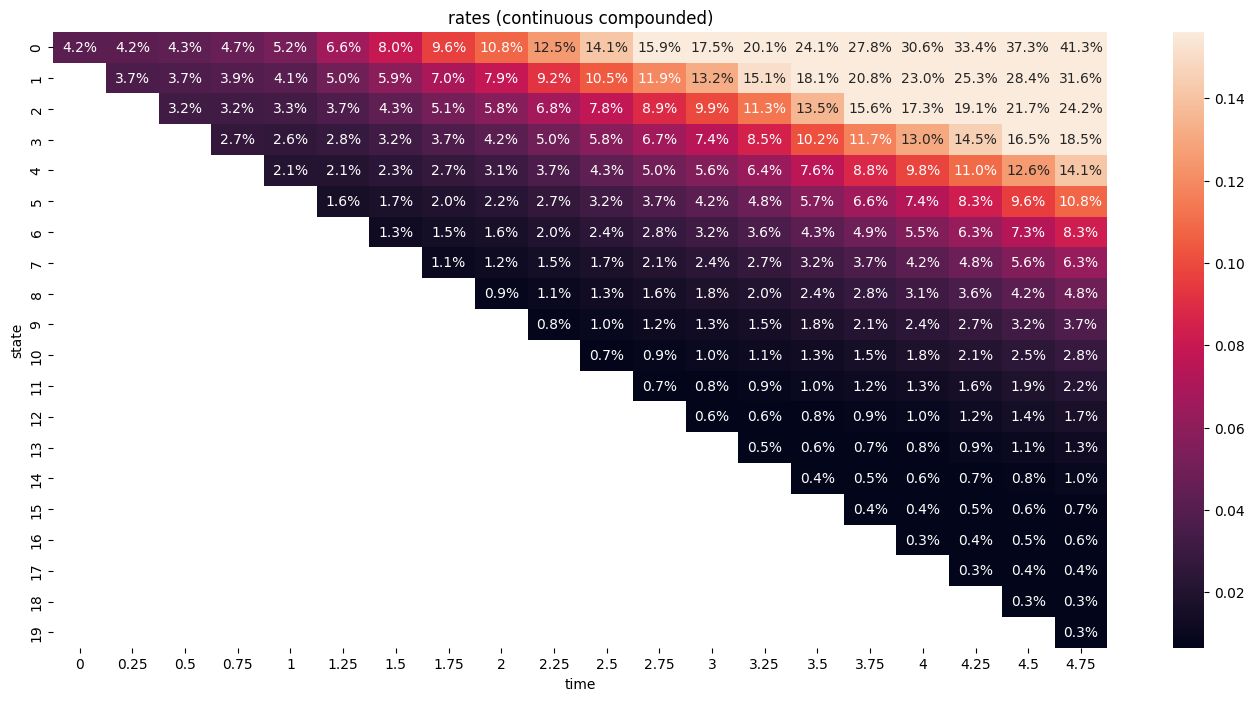

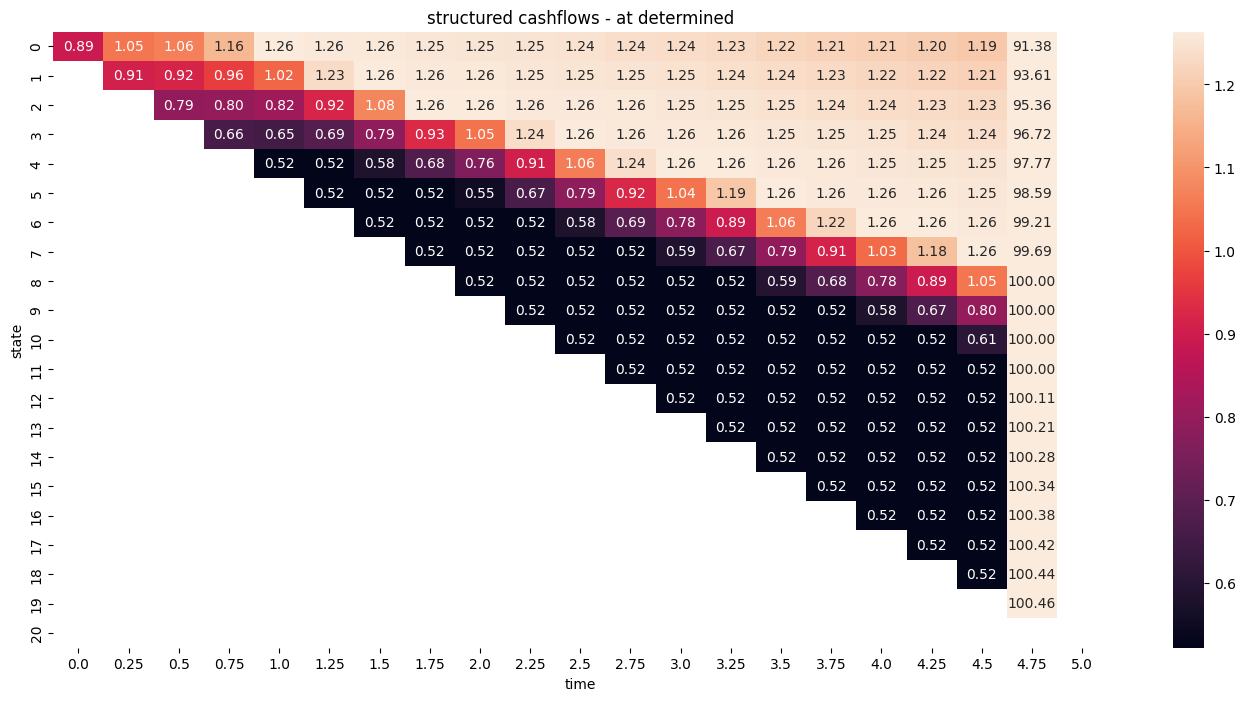

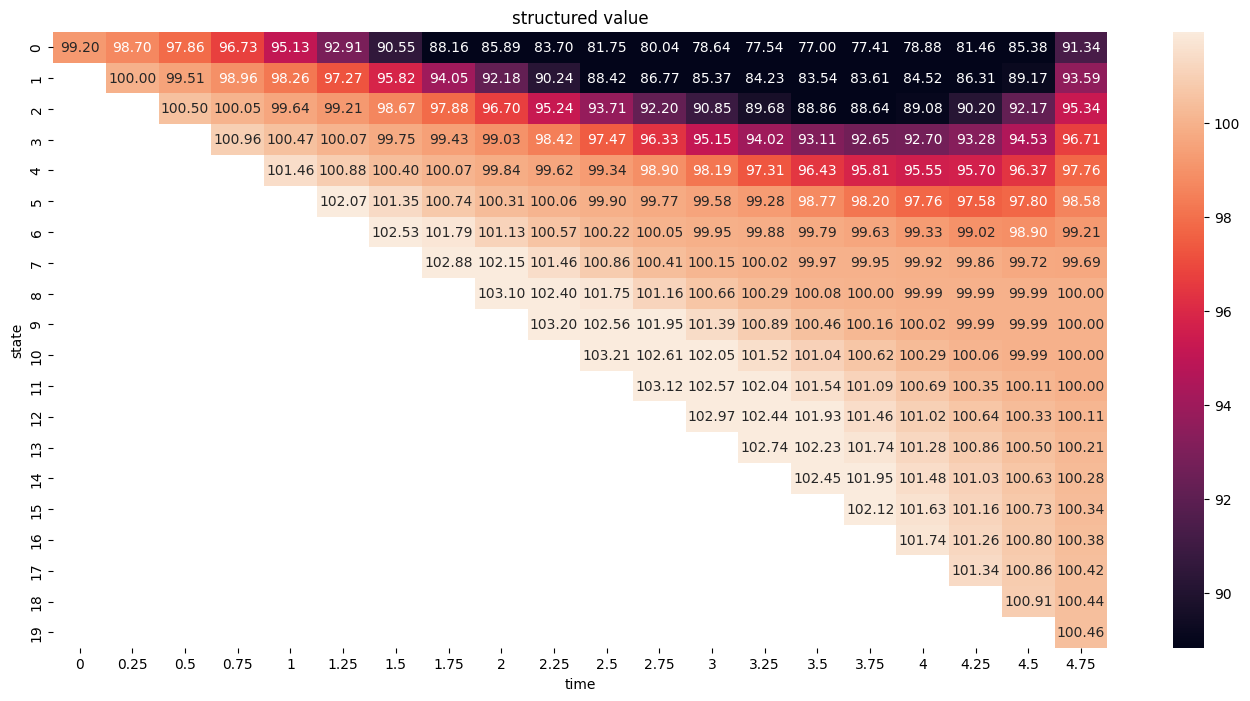

In [48]:
fmt_ratetree = display_bintree_valuation(ratetree,ratetree,title=f'rates (continuous compounded)',charttype=CHARTTYPE,figsize=fsize,fmt='.1%')

display(fmt_ratetree)
display(cf_valtree)
display(fmt_valtree)

### Comparison

Compare the formulaic values from Black's formula (Section 1) with the values from the tree.

In [49]:
nav_comp = (values['black'] * contracts['contracts']).to_frame().rename(columns={0:'black'})
nav_comp['tree'] = values['tree'] * contracts['contracts']
nav_comp.loc['portfolio'] = nav_comp.sum()

nav_comp.loc['bond','tree 2'] = values_binomial.loc['vanilla','bond value']
nav_comp.loc['portfolio','tree 2'] = values_binomial.loc['structured','bond value']

nav_comp.columns = pd.MultiIndex.from_tuples([
    ('portfolio', 'black'),
    ('portfolio', 'tree'),
    ('structured note', 'tree')
])
nav_comp.style.format('{:.2f}',na_rep='').set_caption('Comparison of Model Valuations')

We see that for the "portfolio" of `Section 1`, the valuation is nearly identical between Black's formula and the binomial tree.

***

# Addendum

#### Section 1

The portfolio in Section 1 mimics a common form of a structured note, which pays a floating rate, bounded by a lower and upper limit.

The term corridor note often refers to a version where the coupon goes to zero if the rate is out of bounds. This note, rather, is a "range accrual note" in that the coupon still pays, but it is bounded.

To convince yourself that this is (approximately) what is done in Section 1, consdier that we could replicate a standard floating-rate note with a portfolio of...

* long bond with fixed coupon rate equal to today's 1-period (quarter) spot rate.
* long cap struck at the coupon rate of the bond
* short floor struck at the coupon rate of the bond

Our analysis doesn't perfectly mimic the floating rate note, as the bond's fixed coupon rate slightly differs and the cap/floor are struck ATM (at the $T$-year swap rate.) Still, you'll see that it is an approximate replication of the floating-rate note.

Then, bound the coupon by layering on
* long floor struck OTM
* short cap struck OTM

#### Section 2

`Section 2.3` describes a structured bond which is approximately the same thing as the portfolio from `Section 1`. (It differs slightly in the boundaries.)

### Real-world examples

`YV356038 Corp`
* Issuer: Wells Fargo
* Maturity: 2029
* Bounded: [0,6.5]
* Reference rate: SOFR + 100bps
* Coupon Freq: quarterly

`BNP Float 09/30/29 Corp`
* Issuer: BNP
* Maturity: 2029
* Bounded: [3.25,6]
* Reference rate: SOFR + 0bps
* Coupon Freq: quarterly

## Related Securities: Leveraged (Inverse) Floaters

Note that we could eliminate the OTM cap/floor and instead double the ATM positions to create a **leveraged** floater. Or we could reverse the signs to create a **leveraged inverse** floater. 

These securities featured prominently in the 1990's bankruptcy of Orange County, California.